# Cross-cohort validation and clinical evaluation

This notebook contains three parts of visualization results, AUC distribution before and after feature selection in GGMP while building leave one out (LOO) models for model comparison and validation of feature selection, cross-cohorts microbiome signatures projection for integration of signature across cohorts, and heatmap which used to explore the clincal association with signatures, and subgroups identification.

In [1]:
library("ComplexHeatmap")
library("dendextend")
library("ggpubr")
library("ggsci")
library("ggsignif")
library("knitr")
library("tidyverse")
requireNamespace('circlize')
requireNamespace("RColorBrewer")

options(mc.cores=8,
        repr.plot.width=20, 
        repr.plot.height=10)

Loading required package: grid

ComplexHeatmap version 2.5.5
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



---------------------
Welcome to dendextend version 1.14.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
--------------------

### Model comparison and validation of feature selection

To examine the feature selection, LOO models are built on GGMP dataset, consisting of 14 districts from Guangdong Province. LOO models means models built on 13 districts with 10-fold cross validation, and test in the remaining district. The regional variation limits the model extrapolation in orginial feature set, which means the poor performance in test set prediction. The comparison of model performance whether remove redundant features or not, validate the result of feature selection.

In [2]:
# load LOO model AUC results
data.auc <- read.csv('data/AUC_model_comparison.csv',
                     row.names = 1,
                     check.names = FALSE)
ord.fea <- c('all', 'G', 'S', 'G+S')
ord.dt <- c('train', 'valid', 'test')

data.auc <- data.auc %>%
    mutate(src.fea = factor(consis_from, levels = ord.fea)) %>%
    mutate(src.dt = factor(auc, levels = ord.dt)) %>%
    mutate(auc.score = as.numeric(value)) %>%
    select(c('auc.score', 'src.fea', 'src.dt'))    

head(data.auc)

,auc.score,src.fea,src.dt
,<dbl>,<fct>,<fct>
1,0.6829289,G,test
2,0.6132684,G,test
3,0.6169808,G,test
4,0.6330482,G,test
5,0.6870822,G,test
6,0.6159899,G,test


In [3]:
# get plot object of each dataset (training set, validation set, and testing set)
p. <- list()
for (dt. in ord.dt){
    data.auc %>% filter(src.dt == dt.) -> data.sub
    # wilcox test (FDR correction)
    test.result <- compare_means(auc.score ~ src.fea,
                                 data.sub,
                                 method = "wilcox.test",
                                 paired = FALSE,
                                 p.adjust.method = "fdr")
    print(dt.)
    print(test.result %>%
              as.data.frame %>%
              kable(., "rst"))
    
    # select comparisons and p-values adjusted only if significant (<0.05)
    comparisons <- test.result[test.result$p.adj < 0.05, c('group1', 'group2')] %>%
        t(.) %>%
        as.data.frame(., stringsAsFactors = FALSE) %>%
        as.list
    annotations <- lapply(test.result$p.adj[test.result$p.adj < 0.05], 
                          function(x){
                              ifelse(format(round(x, 5), nsmall=5) == '0.00000', 
                                     '<0.00001', 
                                     format(round(x, 5), nsmall=5))
                          }) %>% unlist
    
    # boxplot of AUC results from different LOO models
    p <- ggplot(data.sub, 
                aes(x=src.fea,
                    y=auc.score,
                    fill=src.fea)) + 
    geom_boxplot(outlier.shape=NA,
                 notch=FALSE) +
    geom_point(position=position_jitterdodge(0.5)) + 
    scale_fill_nejm() +
    ylim(min(data.auc$auc.score) - .05,
         max(data.auc$auc.score) + 0.15) +
    labs(x=dt.,
         y='',
         fill='selected features source') +
    theme_minimal(base_size=12)
    
    if (length(comparisons)) {
        p <- p +
        geom_signif(
            comparisons=comparisons,
            annotations=annotations,
            vjust=0,
            textsize=5,
            size=.5,
            step_increase=0,
            y_position=seq(max(data.auc$auc.score) + .05,
                           max(data.auc$auc.score) + .13,
                           length.out=length(annotations)))
    }
    
    p.[[dt.]] <- p
}

[1] "train"


=========  ======  ======  =========  =======  ========  ========  ========
.y.        group1  group2          p    p.adj  p.format  p.signif  method  
=========  ======  ======  =========  =======  ========  ========  ========
auc.score  all     G       0.0497355  6.0e-02  0.050     *         Wilcoxon
auc.score  all     S       0.0350450  5.3e-02  0.035     *         Wilcoxon
auc.score  all     G+S     0.0000001  6.0e-07  1.0e-07   ****      Wilcoxon
auc.score  G       S       0.5714198  5.7e-01  0.571     ns        Wilcoxon
auc.score  G       G+S     0.0000002  6.0e-07  2.0e-07   ****      Wilcoxon
auc.score  S       G+S     0.0000033  6.7e-06  3.3e-06   ****      Wilcoxon
=========  ======  ======  =========  =======  ========  ========  ========
[1] "valid"


=========  ======  ======  =========  =======  ========  ========  ========
.y.        group1  group2          p    p.adj  p.format  p.signif  method  
=========  ======  ======  =========  =======  ========  ===

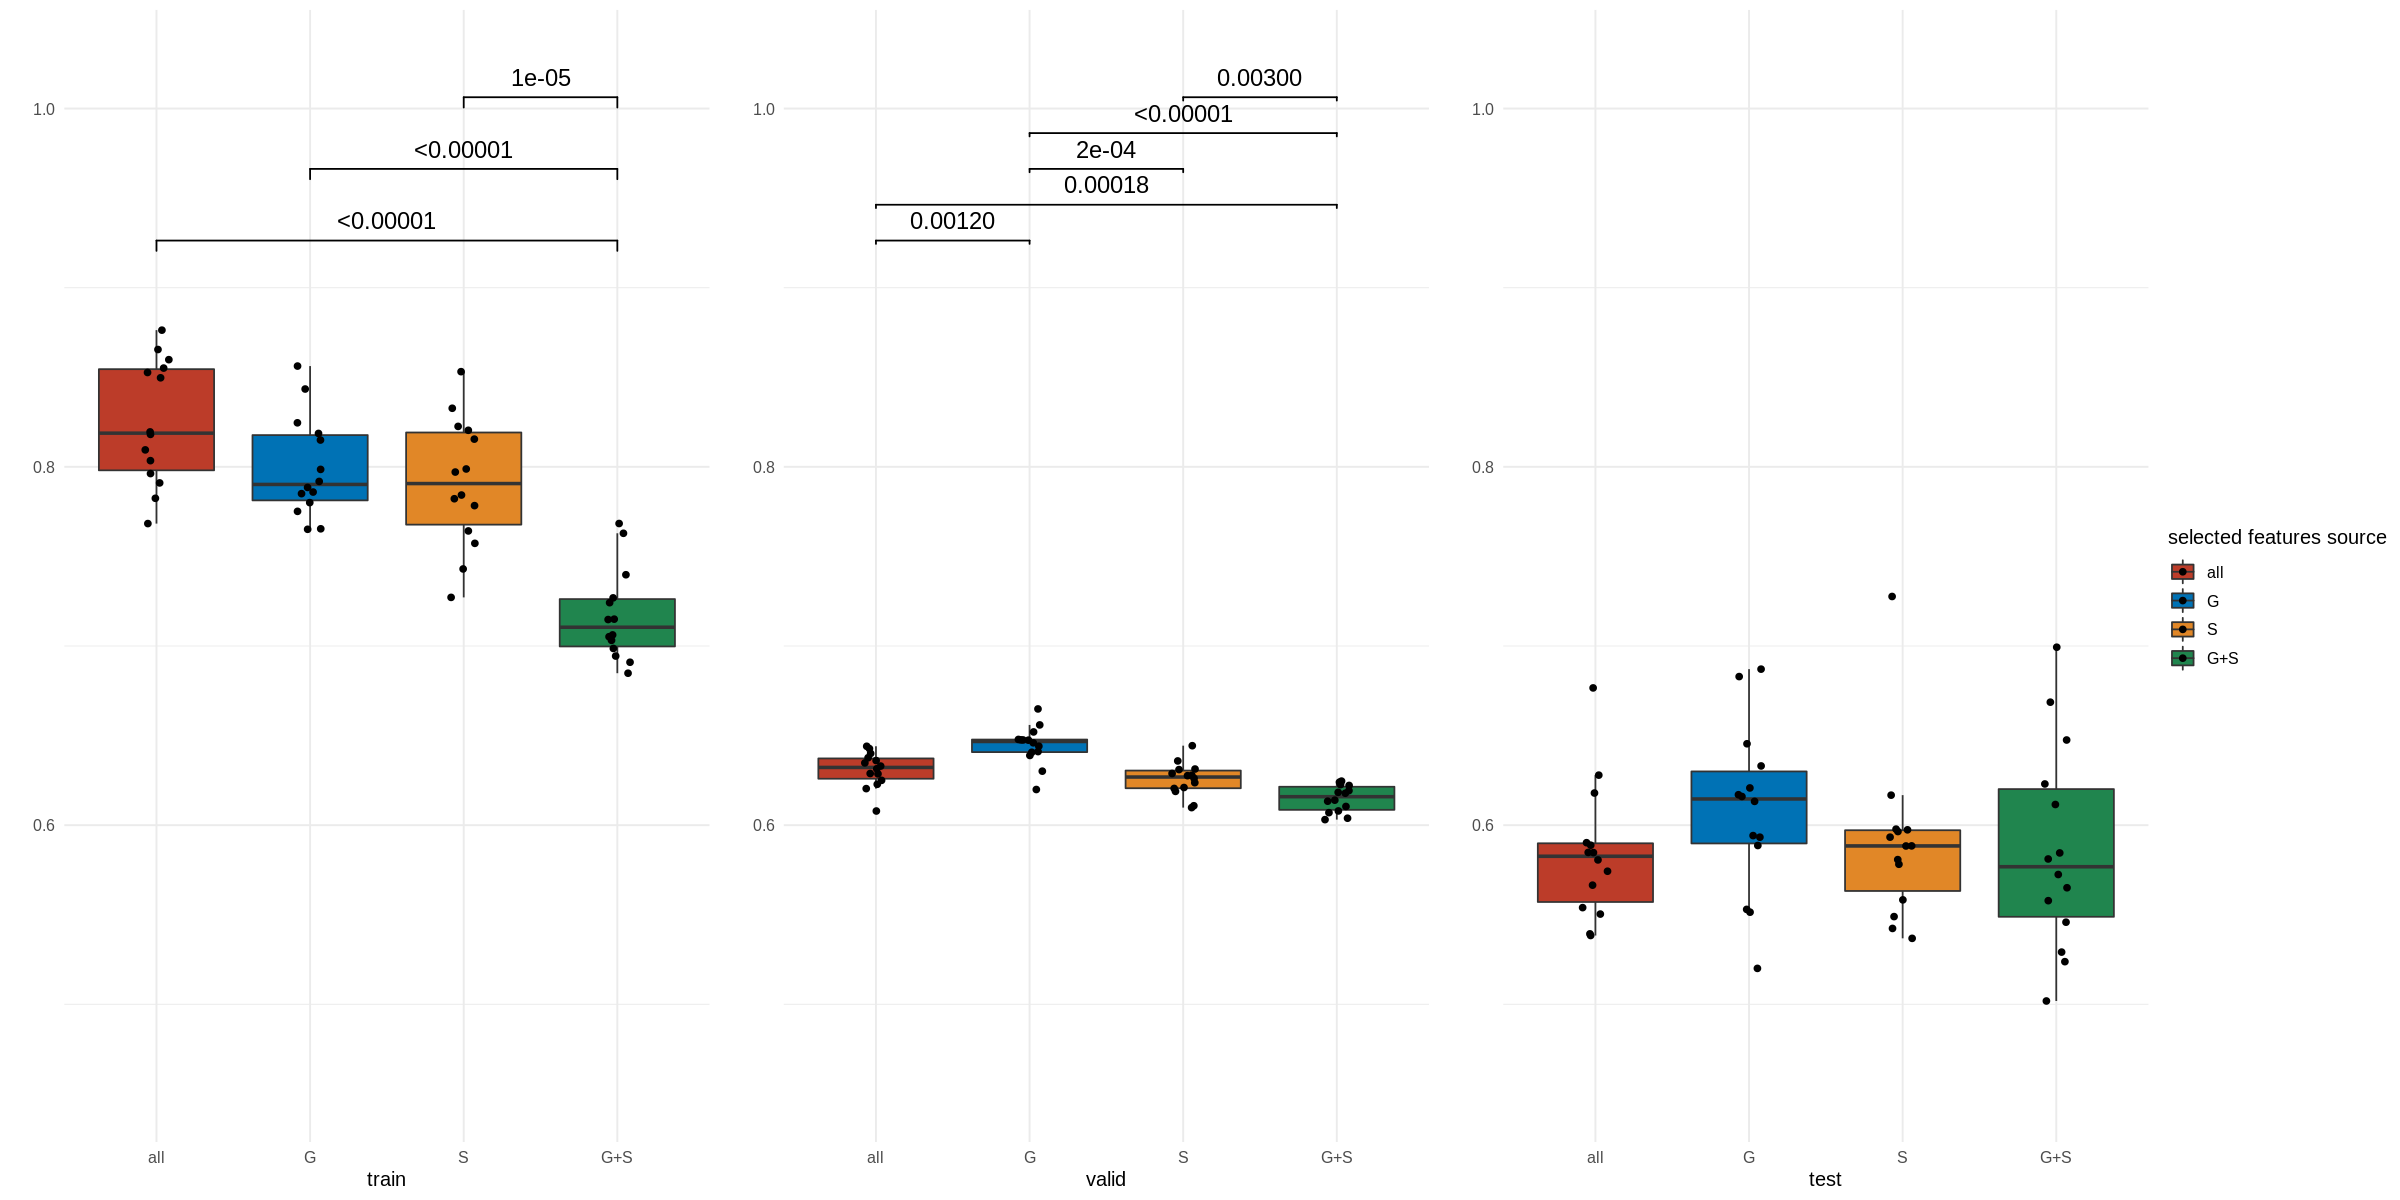

In [4]:
# layout all the boxplot objects
ggarrange(plotlist=p.,
          ncol=3,
          legend = 'right',
          common.legend=TRUE,
          align='hv')

The AUC of model processed by feature selection shows the improvement of overfitting (lower AUC in training set, no significant change in testing set), which also contributes to model extrapolation.

### Integration of signatures across cohorts

The microbiota of GGMP and SGMP is quite unique, that sharply boundaries seperate theses two cohorts in $\beta$-diversity analysis. An obvious regional variation covers up the differences between T2DM and the health. However, extraction of microbiome sigantures, not only reveal the potential microbiome marker for T2DM, also integrate these two cohorts.

In [5]:
data <- read.table('data/Cross_cohort_SHAP_values_integration.tsv',
                   header = TRUE,
                   row.names = 1,
                   check.names = FALSE)
data <- data %>%
    mutate(Cohort=factor(Cohort, levels=c('SGMP', 'GGMP')))

print(dim(data))
head(data)

[1] 3571    4


,Dim1,Dim2,Proba,Cohort
,<dbl>,<dbl>,<dbl>,<fct>
1,-22.28337,-58.673965,0.5991595,GGMP
2,-35.89218,6.018193,0.5263647,GGMP
3,11.59740,-6.257991,0.4403800,GGMP
4,-25.89994,58.589687,0.4402711,GGMP
5,6.21209,18.193830,0.4977175,GGMP
6,-16.95481,-73.141120,0.5894751,GGMP


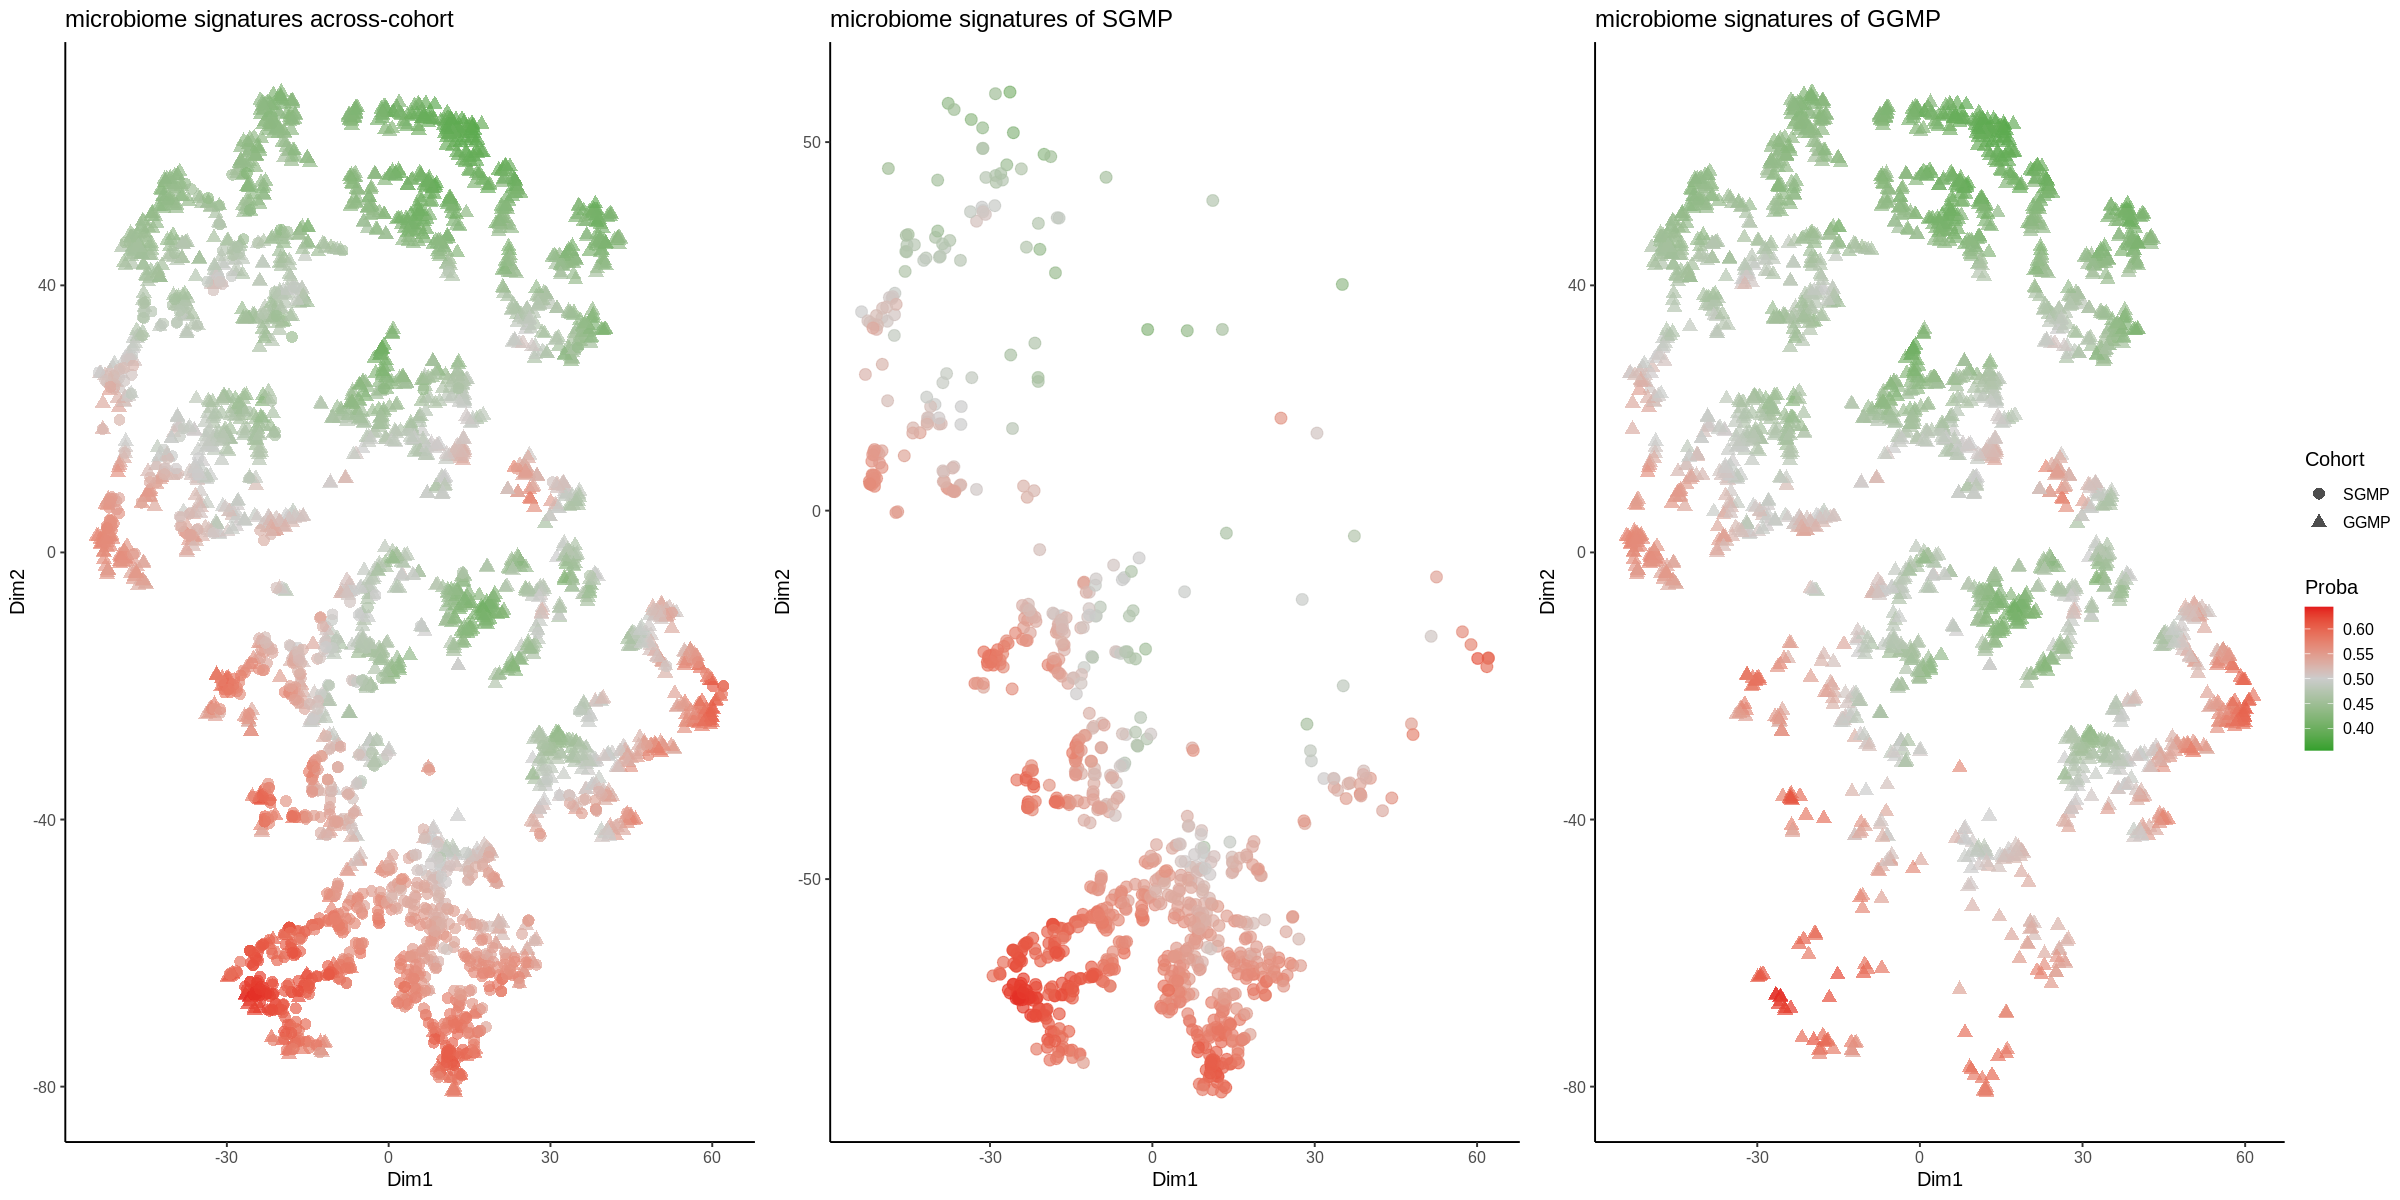

In [6]:
p. <- list()
ggplot(data = data,
       mapping = aes(x=Dim1,
                     y=Dim2)) + 
    geom_point(aes(color = Proba,
                   fill = Proba, 
                   shape = Cohort),
               size = 3,
               alpha = 0.7) + 
    scale_color_gradientn(colours = c('#33A02C', '#CCCCCC', '#E31A1C'),
                          limits = c(0.5 - max(abs(0.5 - max(data$Proba))),
                                     0.5 + max(abs(0.5 - max(data$Proba))))) + 
    scale_fill_gradientn(colours = c('#33A02C', '#CCCCCC', '#E31A1C'),
                         limits = c(0.5 - max(abs(0.5 - max(data$Proba))),
                                    0.5 + max(abs(0.5 - max(data$Proba))))) + 
    labs(title = 'microbiome signatures across-cohort') + 
    theme_classic2(base_size = 12) -> p.[['combined']]

for (cohort. in levels(data$Cohort)){
    ggplot(data = data %>% filter(Cohort == cohort.),
           mapping = aes(x=Dim1,
                         y=Dim2)) +
        geom_point(aes(color=Proba,
                       fill=Proba),
                   shape=c('circle', 'triangle')[which(levels(data$Cohort) == cohort.)],
                   size=3,
                   alpha=0.7) + 
        scale_color_gradientn(colours = c('#33A02C', '#CCCCCC', '#E31A1C'),
                              limits = c(0.5 - max(abs(0.5 - max(data$Proba))),
                                         0.5 + max(abs(0.5 - max(data$Proba))))) +
        scale_fill_gradientn(colours = c('#33A02C', '#CCCCCC', '#E31A1C'),
                             limits = c(0.5 - max(abs(0.5 - max(data$Proba))),
                                        0.5 + max(abs(0.5 - max(data$Proba))))) +
        labs(title = gettextf('microbiome signatures of %s', cohort.)) + 
        theme_classic2(base_size = 12) -> p.[[cohort.]]
}

# layout all the geom points objects
ggarrange(plotlist=p.,
          ncol=3,
          legend = 'right',
          common.legend=TRUE,
          align='hv')

### Clinical association with signatures and subgroups

To well explore the patterns of distribution of microbiome signatures across cohorts, a simple intuitive way is heatmap visualization, gathering the similar samples into clusters and identifying subgroups. 

In [8]:
# load microbiome signatures of GGMP cohort
data.ggmp <- read.table('data/GGMP_avg_SHAP_values.tsv',
                        header = TRUE,
                        row.names = 1,
                        check.names = FALSE)
print(dim(data.ggmp))
head(data.ggmp)

[1] 2603    7


,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
G440606620,0.08332083,0.05215413,-0.001958615,0.05605603,0.07482215,0.12225056,0.01531924
G445224247,0.08412304,0.04200102,-0.029270686,0.07515544,0.01308821,-0.11336178,0.03382147
G440305382,-0.02322834,0.02680033,-0.047205860,-0.08324927,-0.05896039,-0.02097618,-0.03280043
G441502202,-0.04065197,-0.05931144,-0.036578790,0.05428136,-0.05504322,-0.10598241,0.00322468
G445302201,0.07565763,0.01673704,0.057173780,-0.06628276,-0.01556303,-0.11678356,0.03993101
G440981387,0.08637826,-0.06814158,0.052421127,0.07249469,0.03073243,0.15019107,0.03771977


In [9]:
# load microbiome signatures of SGMP cohort
data.sgmp <- read.table('data/SGMP_avg_SHAP_values.tsv',
                        header = TRUE,
                        row.names = 1,
                        check.names = FALSE)
print(dim(data.sgmp))
head(data.sgmp)

[1] 2012    7


,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sam-570,-0.053547427,-0.01730860,-0.042371474,0.07019170,-0.05245297,0.17371200,-0.01915622
sam-477,0.060270634,0.05416694,0.047149338,0.07239134,0.01234787,0.17766026,0.03964786
JN-MF2-15520,-0.042962000,-0.03192333,0.001115068,0.04755152,0.01164996,0.12087089,-0.05344883
JN-MF2-15218,0.081058550,0.06262518,0.053881828,0.07425767,0.04891184,-0.02227118,0.04468122
JN-TMF2-SD0168,-0.008288111,-0.01197517,-0.010651219,-0.04335550,-0.03245286,-0.12445144,0.04463391
sam-792,0.039051265,0.04011645,0.053092632,0.04798025,-0.02181464,-0.02380391,0.04535506


In [10]:
# load microbiome signatures of DFI cohort
data.dfi <- read.table('data/DFI_avg_SHAP_values.tsv',
                       header = TRUE,
                       row.names = 1,
                       check.names = FALSE)
print(dim(data.dfi))
head(data.dfi)

[1] 305   7


,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DF-TMF10-15039,0.07052688,0.024025103,-0.003750537,-0.04202719,0.05979180,-0.02234213,0.045351066
DF-TMF10-BQ1418,-0.04082141,0.062607124,0.054220710,0.06965518,0.07115568,0.12497626,-0.007035812
DF-TMF10-CY3434,0.01981211,-0.080683020,-0.044040470,0.01356739,-0.05291730,0.17362474,0.031828858
DF-TMF10-BQ2518,-0.01688639,-0.023896264,-0.046981800,-0.05552733,-0.06112637,0.17840631,-0.034452017
DF-TMF10-15086,0.08132574,0.016107801,-0.046869810,0.07220623,0.07316289,-0.13056420,0.043575913
DF-TMF10-15100,-0.04027745,0.002725107,0.012788918,0.04722951,0.06676207,0.12317534,-0.000610451


In [11]:
# concatenate these 3 cohorts
data <- rbind(data.ggmp, data.sgmp, data.dfi) %>% as.data.frame %>% .[, order(colSums(abs(.)), decreasing = TRUE)]
print(dim(data))
head(data)

[1] 4920    7


,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
G440606620,0.12225056,0.05605603,0.08332083,0.07482215,0.05215413,-0.001958615,0.01531924
G445224247,-0.11336178,0.07515544,0.08412304,0.01308821,0.04200102,-0.029270686,0.03382147
G440305382,-0.02097618,-0.08324927,-0.02322834,-0.05896039,0.02680033,-0.047205860,-0.03280043
G441502202,-0.10598241,0.05428136,-0.04065197,-0.05504322,-0.05931144,-0.036578790,0.00322468
G445302201,-0.11678356,-0.06628276,0.07565763,-0.01556303,0.01673704,0.057173780,0.03993101
G440981387,0.15019107,0.07249469,0.08637826,0.03073243,-0.06814158,0.052421127,0.03771977


In [12]:
# collect corresponded sample metadata for GGMP cohort
meta.ggmp <- read.table('data/GGMP/sample-metadata.tsv',
                        sep = '\t',
                        header = TRUE,
                        row.names = 1,
                        strip.white = TRUE,
                        check.names = FALSE) %>%
    .[rownames(data.ggmp), ]

df.ggmp <- data.frame(label=factor(unlist(lapply(meta.ggmp$T2DM, function(x){ifelse(x==0 | is.na(x), 'Health', 'Type 2 diabetes')})), 
                                   levels=c('Type 2 diabetes', 'Health')),
                      cohort=rep('GGMP', dim(meta.ggmp)[1]),
                      dataset='train') %>%
    `rownames<-` (rownames(meta.ggmp))
head(df.ggmp)

,label,cohort,dataset
,<fct>,<chr>,<chr>
G440606620,Type 2 diabetes,GGMP,train
G445224247,Health,GGMP,train
G440305382,Health,GGMP,train
G441502202,Health,GGMP,train
G445302201,Health,GGMP,train
G440981387,Health,GGMP,train


In [13]:
# collect corresponded sample metadata for SGMP cohort
meta.sgmp <- read.table('data/SGMP/sample-metadata.tsv',
                        sep = '\t',
                        header = TRUE, 
                        row.names = 1,
                        strip.white = TRUE,
                        check.names = FALSE) %>%
    .[rownames(data.sgmp), ]

df.sgmp <- data.frame(label=factor(meta.sgmp$host_status, levels = c('Type 2 diabetes', 'Health')),
                      cohort=rep('SGMP', dim(meta.sgmp)[1]),
                      dataset=unlist(lapply(meta.sgmp$Districts, 
                                            function(x){ifelse(x %in% c('QD_MF1', 'QD_MF2'),
                                                               'train',
                                                               'test')}))) %>%
    `rownames<-` (rownames(meta.sgmp))
head(df.sgmp)

,label,cohort,dataset
,<fct>,<chr>,<chr>
sam-570,Type 2 diabetes,SGMP,train
sam-477,Type 2 diabetes,SGMP,train
JN-MF2-15520,Type 2 diabetes,SGMP,test
JN-MF2-15218,Type 2 diabetes,SGMP,test
JN-TMF2-SD0168,Type 2 diabetes,SGMP,test
sam-792,Type 2 diabetes,SGMP,train


In [14]:
# collect corresponded sample metadata for DFI cohort
meta.dfi <- read.table('data/DFI/sample-metadata.tsv',
                       sep = '\t',
                       header = TRUE,
                       row.names = 1,
                       strip.white = TRUE,
                       check.names = FALSE) %>%
    .[rownames(data.dfi), ]

df.dfi <- data.frame(label=factor(meta.dfi$host_status, levels = c('Early', 'Mid', 'Later', 'Health')),
                     cohort=rep('DFI', dim(meta.dfi)[1]),
                     dataset=rep('test', dim(meta.dfi)[1])) %>%
    `rownames<-` (rownames(meta.dfi))
head(df.dfi)

,label,cohort,dataset
,<fct>,<chr>,<chr>
DF-TMF10-15039,Health,DFI,test
DF-TMF10-BQ1418,Mid,DFI,test
DF-TMF10-CY3434,Later,DFI,test
DF-TMF10-BQ2518,Mid,DFI,test
DF-TMF10-15086,Health,DFI,test
DF-TMF10-15100,Health,DFI,test


In [15]:
# concatenate sample metadata of 3 cohorts
df <- rbind(df.ggmp, df.sgmp, df.dfi) %>% 
    .[rownames(data), ]  %>%
    mutate(cohort=factor(cohort, levels=c('GGMP', 'SGMP', 'DFI'))) %>%
    mutate(dataset=factor(dataset, levels=c('train', 'test'))) %>%
    `rownames<-` (rownames(data))

In [16]:
# transform SHAP values to prediction probability
expit <- function(x){
    exp(x)/(1+exp(x))
}

df$proba <- unlist(lapply(rowSums(data), expit))
print(dim(df))
df %>%
    group_by(cohort, label) %>%
    tally()

[1] 4920    4


cohort,label,n
<fct>,<fct>,<int>
GGMP,Type 2 diabetes,604
GGMP,Health,1999
SGMP,Type 2 diabetes,1620
SGMP,Health,392
DFI,Health,55
DFI,Early,85
DFI,Mid,78
DFI,Later,87


`summarise()` ungrouping output (override with `.groups` argument)





================  =========
cluster           mean.pred
================  =========
T2DM_subgroup1    0.5089268
T2DM_subgroup2    0.5128865
T2DM_subgroup3    0.5580812
Health_subgroup1  0.4569474
Health_subgroup2  0.4908990
================  =========


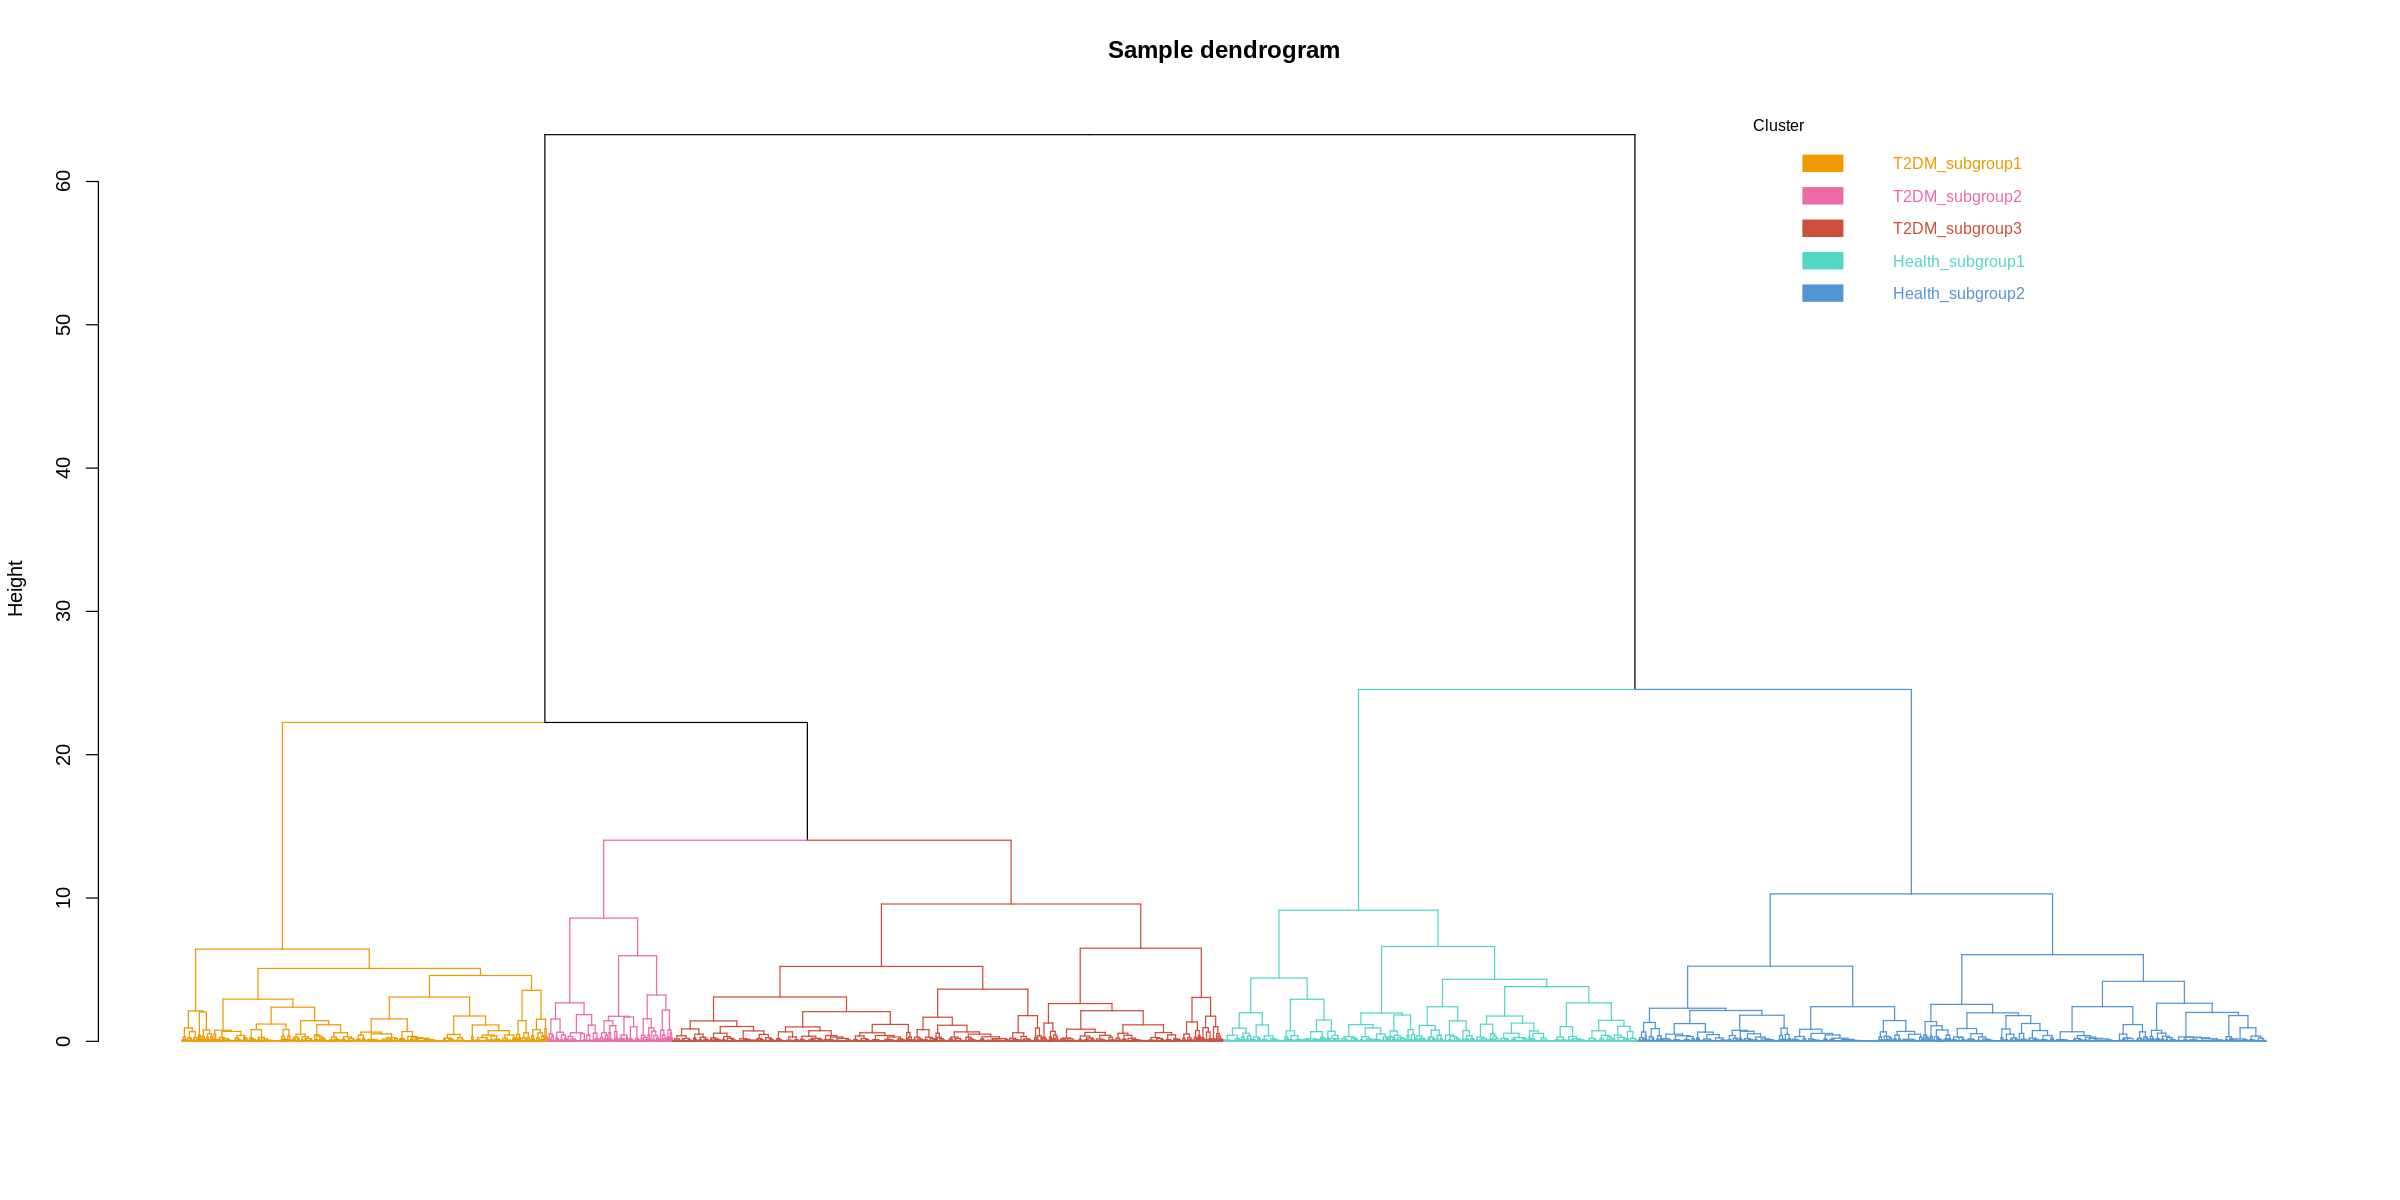

In [20]:
# generate complex heatmap
# -- 1. dendrogram for heatmap ----------------------------
k <- 5  # number of clusters, optimized via function fviz_nbclust,
        # based on total within sum of square (see Supp for detail)
samples.cor <- cor(t(data), use = 'pairwise.complete.obs', method = 'pearson')
dendro <- hclust(as.dist(1 - samples.cor),
                 method = 'ward.D2')
fit <- cutree(dendro, k = k)
sub.grp <- factor(fit, labels = c('T2DM_subgroup1',
                                  'T2DM_subgroup2',
                                  'T2DM_subgroup3',
                                  'Health_subgroup1',
                                  'Health_subgroup2'), 
                  levels = unique(fit[dendro$order]))

# add cluster information to samples metadata
df$cluster <- sub.grp
print(df %>% group_by(cluster) %>% summarize(mean.pred=mean(proba)) %>% kable(., "rst"))

# visualize dendrogram and cluster information
cluster.col <- c('orange2','hotpink2','tomato3', '#54D6C6','#5295D2')
dend.ext <- color_branches(dendro,
                           k = k,
                           col = cluster.col,
                           warn = FALSE) %>%
    set('labels_col', 'white') %>%
    set('labels_cex', 0.01)

plot(dend.ext,
     xlab = '',
     ylab = 'Height',
     sub = '',
     main = 'Sample dendrogram',
     cex = 3)
legend('topright',
       legend = c(paste0('T2DM_subgroup', 1:3),
                  paste0('Health_subgroup', 1:2)),
       fill = cluster.col,
       border = cluster.col,
       text.col = cluster.col,
       cex = 0.8,
       bty = "n",
       title = "Cluster",
       title.col = "black",
       title.adj = 0)

In [18]:
# generate complex heatmap
# -- 2. prepare annotation for heatmap --------------------
df$label. <- factor(paste(df$cohort, df$label, sep = '-'),
                  levels = c('GGMP-Type 2 diabetes',
                            'GGMP-Health',
                            'SGMP-Type 2 diabetes',
                            'SGMP-Health',
                            'DFI-Early',
                            'DFI-Mid',
                            'DFI-Later',
                            'DFI-Health'))
HeatmapAnnotation(df = df[, c('cluster', 'dataset', 'label.', 'proba')],
                  col = list(cluster=cluster.col %>% `names<-` (levels(df$cluster)),
                             dataset=c('orange', 'lightblue') %>% `names<-` (levels(df$dataset)),
                             label.=c(RColorBrewer::brewer.pal(11, 'RdYlGn')[c(4, 8, 2, 10)],
                                      RColorBrewer::brewer.pal(7, 'Blues')[c(3, 4, 5, 7)]) %>%
                                         `names<-` (levels(df$label.)),
                             proba=circlize::colorRamp2(c(0.2, 0.5, 0.8),
                                                        c('grey80', 'white', 'firebrick1')))) -> anno



=============================================================================================================  ===
\                                                                                                              x  
=============================================================================================================  ===
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus                   g1 
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium  g2 
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium                g3 
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira                    g4 
k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__                  g5 
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__              

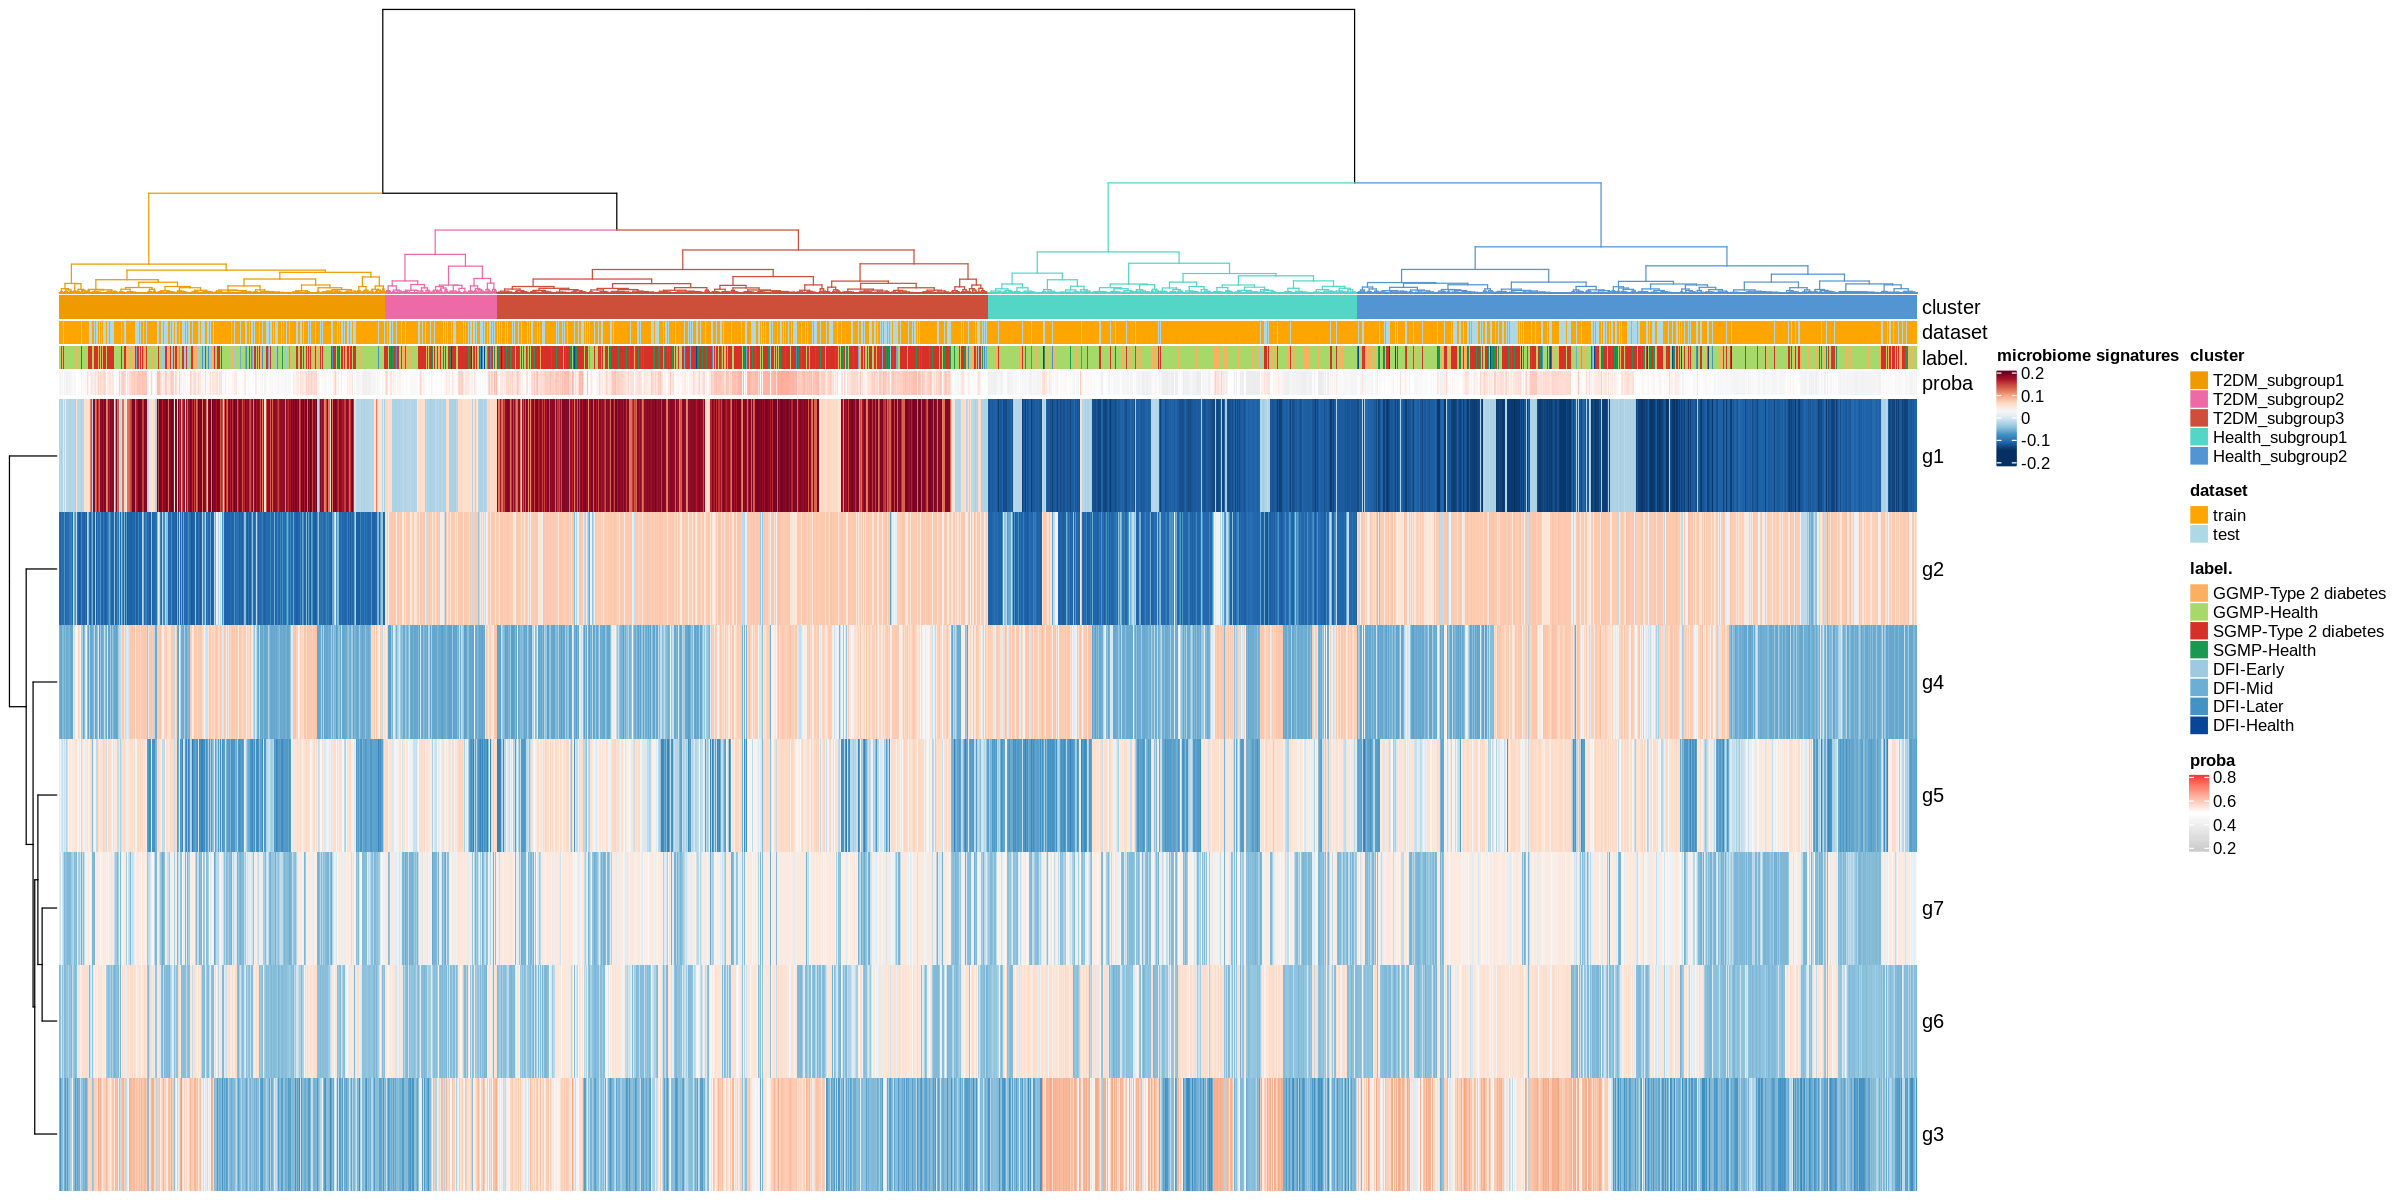

In [19]:
# generate complex heatmap
# -- 3. plot heatmap --------------------------------------
nms <- paste0('g', 1:dim(data)[2]) %>% `names<-` (colnames(data))
Heatmap(t(data %>% `colnames<-` (nms)),
        name = 'microbiome signatures',
        top_annotation = anno,
        col = rev(RColorBrewer::brewer.pal(11, "RdBu")),
        cluster_columns = dend.ext,
        column_dend_height = unit(6, "cm"),
        show_column_names = F) -> hmp

print(kable(nms, "rst"))
hmp

There are 2 health subgroups and 3 T2DM subgroups identified based on microbiome signatures clustering. Two genus <i>Lactobacillus</i> and <i>Bifidobacterium</i> have great effect on clustering. <i>Lactobacillus</i> drives samples into health clusters and T2DM clusters, in the meanwhile <i>Bifidobacterium donating</i> to the subgroups in healthy samples and T2DM samples.